In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import math
from matplotlib import pyplot as plt
import matplotlib as mpl
from copy import copy,deepcopy

sys.path.append('./Emanuele_git/tree-language/modules/')

from logger_tree_language import get_logger
from models import TransformerClassifier,FFNN
from models_custom import TransformerClassifierNoFeedforward
from BeliefPropagation import masked_inference,MLM_BP_accuracy
from masked_language_modeling import train_model_mlm, mask_sequences
#from plotting import plot_training_history
from pytorch_utilities import create_linear_lr_schedulers, lr_linear_update
from pytorch_utilities import load_checkpoint
from Potts_inference import PottsModel,train_Potts
from models import replace_decoder_with_classification_head, freeze_encoder_weights, get_encoder_layer_residuals
from model_evaluation_tree_language import compute_accuracy
from training import train_model

logger = get_logger('transformer_encoder_pretraining')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%load_ext autoreload
%autoreload 2

In [2]:
from ancestor_probing import train_model_ancestor_probe

In [3]:
def get_model(MODEL_DIR,device):
    checkpoint_epochs = sorted([
        int(f.split('_')[-1].split('.')[0])
        for f in os.listdir(MODEL_DIR)
        if '.pt' in f
    ])

    selected_checkpoint_epoch = checkpoint_epochs[-1]

    checkpoint_id = [f for f in os.listdir(MODEL_DIR) if f'{selected_checkpoint_epoch}.pt' in f][0]

    n_layer = 4

    model_params = dict(
        seq_len=seq_len,
        embedding_size=embedding_size,
        n_tranformer_layers=n_layer,  # Good: 4
        n_heads=n_head,
        vocab_size=vocab_size,
        positional_encoding=True,
        n_special_tokens=1,  # We assume the special tokens correspond to the last `n_special_tokens` indices.
        embedding_agg=None,
        decoder_hidden_sizes=[],  # Good: [64]
        decoder_activation='relu',  # Good: 'relu'
        decoder_output_activation='identity'
    )
    # Get the model
    pretrained_MLM = TransformerClassifier(**model_params).to(device=device)

    checkpoint_path = os.path.join(MODEL_DIR,checkpoint_id)
    checkpoint = torch.load(checkpoint_path,map_location=device)

    pretrained_MLM.load_state_dict(checkpoint['model_state_dict'])
    training_history = checkpoint['training_history']
        
    # Send loaded model and optimizer to the chosen device.
    pretrained_MLM = pretrained_MLM.to(device=device)

    return pretrained_MLM

In [4]:
def get_model_truncated(MODEL_DIR,device,k):
    checkpoint_epochs = sorted([
        int(f.split('_')[-1].split('.')[0])
        for f in os.listdir(MODEL_DIR)
        if '.pt' in f
    ])

    selected_checkpoint_epoch = checkpoint_epochs[-1]

    checkpoint_id = [f for f in os.listdir(MODEL_DIR) if f'{selected_checkpoint_epoch}.pt' in f][0]

    n_layer = 4

    model_params = dict(
        seq_len=seq_len,
        embedding_size=embedding_size,
        n_tranformer_layers=n_layer,  # Good: 4
        n_heads=n_head,
        vocab_size=vocab_size,
        positional_encoding=True,
        n_special_tokens=1,  # We assume the special tokens correspond to the last `n_special_tokens` indices.
        embedding_agg=None,
        decoder_hidden_sizes=[64],  # Good: [64]
        decoder_activation='relu',  # Good: 'relu'
        decoder_output_activation='identity'
    )
    # Get the model
    pretrained_MLM = TransformerClassifier(**model_params).to(device=device)

    checkpoint_path = os.path.join(MODEL_DIR,checkpoint_id)
    checkpoint = torch.load(checkpoint_path,map_location=device)

    pretrained_MLM.load_state_dict(checkpoint['model_state_dict'])
    training_history = checkpoint['training_history']

    n_layer = 4 - k

    model_params = dict(
        seq_len=seq_len,
        embedding_size=embedding_size,
        n_tranformer_layers=n_layer,  # Good: 4
        n_heads=n_head,
        vocab_size=vocab_size,
        positional_encoding=True,
        n_special_tokens=1,  # We assume the special tokens correspond to the last `n_special_tokens` indices.
        embedding_agg=None,
        decoder_hidden_sizes=[],  # Good: [64]
        decoder_activation='relu',  # Good: 'relu'
        decoder_output_activation='identity'
    )
    # Get the model
    model = TransformerClassifier(**model_params).to(device=device)

    if n_layer > 1:
        model.encoder_layer.load_state_dict(pretrained_MLM.encoder_layer.state_dict())
        for i in range(n_layer):
            model.transformer_encoder.layers[i].load_state_dict(pretrained_MLM.transformer_encoder.layers[i].state_dict())
    else:
        model.encoder_layer.load_state_dict(pretrained_MLM.encoder_layer.state_dict())
        model.transformer_encoder.layers[0].load_state_dict(pretrained_MLM.transformer_encoder.layers[0].state_dict())

    model.positional_embedding.load_state_dict(pretrained_MLM.positional_embedding.state_dict())
    model.input_embedding.load_state_dict(pretrained_MLM.input_embedding.state_dict())
        
    # Send loaded model and optimizer to the chosen device.
    model = model.to(device=device)

    return model

In [5]:
mpl.rcdefaults()
#plt.rc('text', usetex=True)
plt.rcParams.update({'font.size': 18})
%matplotlib inline

In [6]:
seeds = [0,1,15,31]
sigma = 1.0
epsilon = 0.0
q = 4
l = 4

[_,_,_,_,x0s,xis,M_s] = np.load('./sim_data/labeled_data_fixed_LARGE_{}_{}_{}_{:.5f}.npy'.format(q,l,sigma,epsilon),allow_pickle=True)

n_layers = [1,2,4,5]
n_heads = [1]
embedding_size = 128
seq_len = 2**l

seed = seeds[0]
n_layer = n_layers[-2]
n_head = n_heads[0]

xi = xis[:,:,seed]
x0 = x0s[:,seed]

vocab_size = q+1

In [7]:
p = 2**18
#MODEL_DIR = './models/model_MLM_1mask_wfactorizedvalNew_{}_{}_{:.2f}_{:.5f}_{}_{}_{}'.format(q,l,sigma,epsilon,seed,p,n_layer)
MODEL_DIR = './models/model_MLM_1mask_wfactorizedvalNew_LinearReadout_{}_{}_{:.2f}_{:.5f}_{}_{}_{}'.format(q,l,sigma,epsilon,seed,p,n_layer)

In [7]:
p = 2**18
k = l-2
MODEL_DIR = './models/model_MLM_1mask_factorizedNew_{}_{}_{:.2f}_{:.5f}_{}_{}_{}_{}'.format(q,l,sigma,epsilon,seed,p,n_layer,k)

In [8]:
checkpoint_epochs = sorted([
    int(f.split('_')[-1].split('.')[0])
    for f in os.listdir(MODEL_DIR)
    if '.pt' in f
])

selected_checkpoint_epoch = checkpoint_epochs[-1]


checkpoint_id = [f for f in os.listdir(MODEL_DIR) if f'{selected_checkpoint_epoch}.pt' in f][0]

In [9]:
print(checkpoint_id)

model__epoch_2000.pt


In [10]:
model_params = dict(
        seq_len=seq_len,
        embedding_size=embedding_size,
        n_tranformer_layers=n_layer,  # Good: 4
        n_heads=n_head,
        vocab_size=vocab_size,
        positional_encoding=True,
        n_special_tokens=1,  # We assume the special tokens correspond to the last `n_special_tokens` indices.
        embedding_agg=None,
        decoder_hidden_sizes=[64],  # Good: [64]
        decoder_activation='relu',  # Good: 'relu'
        decoder_output_activation='identity'
    )
    # Get the model
pretrained_MLM = TransformerClassifier(**model_params).to(device=device)

checkpoint_path = os.path.join(MODEL_DIR,checkpoint_id)
checkpoint = torch.load(checkpoint_path,map_location=device)

pretrained_MLM.load_state_dict(checkpoint['model_state_dict'])
training_history = checkpoint['training_history']
    
# Send loaded model and optimizer to the chosen device.
pretrained_MLM = pretrained_MLM.to(device=device)

/home/Garnier/miniconda3/envs/default/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [11]:
training_history['val_accuracy']

[0.171999990940094,
 0.49480000138282776,
 0.5461999773979187,
 0.5787999629974365,
 0.6078000068664551,
 0.6247999668121338,
 0.6283999681472778,
 0.6413999795913696,
 0.6398999691009521,
 0.6453999876976013,
 0.6496999859809875,
 0.6525999903678894,
 0.6513999700546265,
 0.652999997138977,
 0.6553999781608582,
 0.6485999822616577,
 0.6574999690055847,
 0.6581000089645386,
 0.6502999663352966,
 0.656499981880188,
 0.6687999963760376,
 0.6643999814987183,
 0.6620999574661255,
 0.659500002861023,
 0.6690999865531921,
 0.6577000021934509,
 0.6729999780654907,
 0.6686999797821045,
 0.6628999710083008,
 0.6609999537467957,
 0.675599992275238,
 0.6687999963760376,
 0.666700005531311,
 0.6635000109672546,
 0.6696000099182129,
 0.6645999550819397,
 0.6661999821662903,
 0.6608999967575073,
 0.6635000109672546,
 0.6773999929428101,
 0.6696000099182129,
 0.6574999690055847,
 0.6679999828338623,
 0.6678000092506409,
 0.6699000000953674,
 0.6636999845504761,
 0.670199990272522,
 0.6625999808311462

In [12]:
pretrained_MLM

TransformerClassifier(
  (input_embedding): Embedding(5, 128)
  (positional_embedding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (linear1): Linear(in_features=128, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=128, bias=True)
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias

In [13]:
model = deepcopy(pretrained_MLM)

In [14]:
decoder_hidden_dim = []
n_classes = q
decoder_activation = 'relu'
decoder_batch_normalization = False
decoder_dropout_p = None

In [15]:
model.decoder = FFNN(
        dims=(
            [model.embedding_size]
            + decoder_hidden_dim
            + [n_classes]
        ),
        activation=decoder_activation,
        output_activation='identity',
        batch_normalization=decoder_batch_normalization,
        dropout_p=decoder_dropout_p,
        concatenate_last_dim=False
    )

In [16]:
model.decoder
model.to(device=device)

TransformerClassifier(
  (input_embedding): Embedding(5, 128)
  (positional_embedding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (linear1): Linear(in_features=128, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=128, bias=True)
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias

In [17]:
freeze_encoder_weights(model,trainable_modules=['decoder'])

2024-07-30 15:47:10,229 - transformer_encoder_pretraining - INFO - Module: input_embedding| N parameters: 640 | Parameters trainable: False | Training mode: False
2024-07-30 15:47:10,229 - transformer_encoder_pretraining - INFO - Module: positional_embedding| N parameters: 0 | Parameters trainable: True | Training mode: False
2024-07-30 15:47:10,229 - transformer_encoder_pretraining - INFO - Module: encoder_layer| N parameters: 593024 | Parameters trainable: False | Training mode: False
2024-07-30 15:47:10,230 - transformer_encoder_pretraining - INFO - Module: transformer_encoder| N parameters: 2372096 | Parameters trainable: False | Training mode: False
2024-07-30 15:47:10,230 - transformer_encoder_pretraining - INFO - Module: embedding_agg_layer| N parameters: 0 | Parameters trainable: True | Training mode: False
2024-07-30 15:47:10,230 - transformer_encoder_pretraining - INFO - Module: decoder| N parameters: 516 | Parameters trainable: True | Training mode: True


In [18]:
model

TransformerClassifier(
  (input_embedding): Embedding(5, 128)
  (positional_embedding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (linear1): Linear(in_features=128, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=128, bias=True)
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias

In [19]:
#ancestry_layer = l-2
ancestry_layer = 1

[_,_,_,_,xs_ancestor,xis,_,_] = np.load('./sim_data/ancestor_data_fixed_{}_{}_{}_{:.5f}_{}.npy'.format(q,l,sigma,epsilon,ancestry_layer),allow_pickle=True)

x_ancestor = xs_ancestor[:,:,seed]
xi = xis[:,:,seed]

In [20]:
leaves = torch.from_numpy(xi.T).to(device=device).to(dtype=torch.int64)
ancestors = torch.nn.functional.one_hot(torch.from_numpy(x_ancestor.T).to(dtype=torch.int64), num_classes=q).to(dtype=torch.float32).to(device=device)
#ancestors = torch.from_numpy(x_ancestor).to(device=device).to(dtype=torch.int64)


In [21]:
print(ancestors.shape)
print(leaves.shape)

torch.Size([100000, 2, 4])
torch.Size([100000, 16])


In [33]:
upsample_factor = 2**l//2**ancestry_layer
upsampled_ancestors = ancestors.repeat_interleave(upsample_factor, dim=1)
print(upsampled_ancestors.shape)

torch.Size([100000, 16, 4])


In [23]:
loss_fn = torch.nn.CrossEntropyLoss(reduction='none')

In [24]:
optimizer_params = dict(
        lr=1e-4, # correcting for the very small loss due to single token masking
        betas=(0.9, 0.999),
        eps=1e-08,  # 1e-6 for BERT.
        weight_decay=0  # 0.01 for BERT.
    )
optimizer = torch.optim.Adam(
    params=model.parameters(),
    **optimizer_params
)

In [25]:
N_train = int(1e4)
batch_size = 32

x_train = leaves[:N_train,:]
y_train = upsampled_ancestors[:N_train,:,:]
print(x_train.shape,y_train.shape)

N_val = int(1e3)
x_test = leaves[-N_val:,:]
y_test = upsampled_ancestors[-N_val:,:,:]

torch.Size([10000, 16]) torch.Size([10000, 16, 4])


In [26]:
n_epochs = 100

model,optimizer,training_history = train_model_ancestor_probe((x_train,y_train),model,n_epochs,batch_size,optimizer,val_sequences = (x_test,y_test))

2024-07-30 15:47:16,050 - transformer_encoder_pretraining - INFO - Training model


100%|██████████| 100/100 [02:18<00:00,  1.38s/it, learning_rate=0.0001, training_accuracy=tensor(0.4699), training_loss=tensor(10.4933), val_accuracy=tensor(0.5153, device='cuda:0'), val_loss=tensor(10.2931, device='cuda:0')]
2024-07-30 15:49:35,006 - transformer_encoder_pretraining - INFO - Last epoch: 100


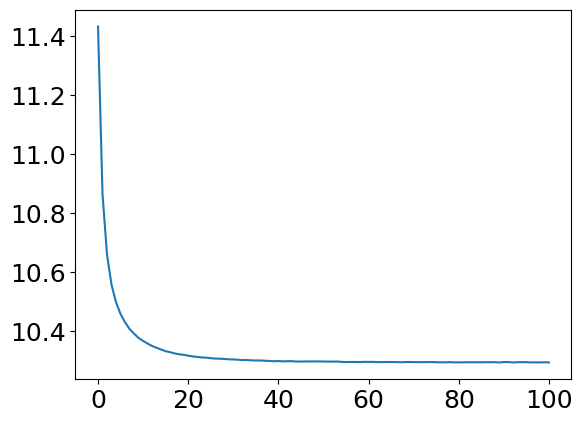

In [27]:
plt.plot(training_history['val_loss'])

### Do things properly

In [7]:
P = 2**np.arange(14,15)
print(P)

p = 2**18

ks = np.arange(l+1)
levels = np.arange(l-1,0,-1)

print(levels)

[16384]
[3 2 1]


In [8]:
loss_fn = torch.nn.CrossEntropyLoss(reduction='none')
optimizer_params = dict(
        lr=1e-4, # correcting for the very small loss due to single token masking
        betas=(0.9, 0.999),
        eps=1e-08,  # 1e-6 for BERT.
        weight_decay=0  # 0.01 for BERT.
    )
decoder_hidden_dim = []
n_classes = q
decoder_activation = 'relu'
decoder_batch_normalization = False
decoder_dropout_p = None
n_epochs = 100
batch_size = 32

N_val = int(1e4)
val_accuracies = np.empty((n_epochs+1,len(ks),len(levels),len(P)))

In [9]:
for i in range(len(ks)):
    if ks[i] == 0:
        #MODEL_DIR = './models/model_MLM_1mask_wfactorizedvalNew_{}_{}_{:.2f}_{:.5f}_{}_{}_{}'.format(q,l,sigma,epsilon,seed,p,n_layer)
        MODEL_DIR = './models/model_MLM_1mask_wfactorizedvalNew_LinearReadout_{}_{}_{:.2f}_{:.5f}_{}_{}_{}'.format(q,l,sigma,epsilon,seed,p,n_layer)
    else: 
        #MODEL_DIR = './models/model_MLM_1mask_factorizedNew_{}_{}_{:.2f}_{:.5f}_{}_{}_{}_{}'.format(q,l,sigma,epsilon,seed,p,n_layer,ks[i])
        MODEL_DIR = './models/model_MLM_1mask_factorizedNew_LinearReadout_{}_{}_{:.2f}_{:.5f}_{}_{}_{}_{}'.format(q,l,sigma,epsilon,seed,p,n_layer,ks[i])
    pretrained_MLM = get_model(MODEL_DIR,device)
    for j in range(len(levels)):
        [_,_,_,_,xs_ancestor,xis,_,_] = np.load('./sim_data/ancestor_data_fixed_{}_{}_{}_{:.5f}_{}.npy'.format(q,l,sigma,epsilon,levels[j]),allow_pickle=True)
        x_ancestor = xs_ancestor[:,:,seed]
        xi = xis[:,:,seed]
        leaves = torch.from_numpy(xi.T).to(device=device).to(dtype=torch.int64)
        ancestors = torch.nn.functional.one_hot(torch.from_numpy(x_ancestor.T).to(dtype=torch.int64), num_classes=q).to(dtype=torch.float32).to(device=device)
        upsample_factor = 2**l//2**levels[j]
        upsampled_ancestors = ancestors.repeat_interleave(upsample_factor, dim=1)
        x_test = leaves[-N_val:,:]
        y_test = upsampled_ancestors[-N_val:,:,:]
        for k in range(len(P)):
            x_train = leaves[:P[k],:]
            y_train = upsampled_ancestors[:P[k],:,:]
            model = deepcopy(pretrained_MLM)
            model.decoder = FFNN(
                dims=(
                    [model.embedding_size]
                    + decoder_hidden_dim
                    + [n_classes]
                ),
                activation=decoder_activation,
                output_activation='identity',
                batch_normalization=decoder_batch_normalization,
                dropout_p=decoder_dropout_p,
                concatenate_last_dim=False
            )
            model = model.to(device=device)
            freeze_encoder_weights(model,trainable_modules=['decoder'])
            optimizer = torch.optim.Adam(
                params=model.parameters(),
                **optimizer_params
            )
            model,optimizer,training_history = train_model_ancestor_probe((x_train,y_train),model,n_epochs,batch_size,optimizer,val_sequences = (x_test,y_test))
            val_accuracies[:,i,j,k] = training_history['val_accuracy']

/home/Garnier/miniconda3/envs/default/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
2024-08-06 15:51:00,545 - transformer_encoder_pretraining - INFO - Module: input_embedding| N parameters: 640 | Parameters trainable: False | Training mode: False
2024-08-06 15:51:00,547 - transformer_encoder_pretraining - INFO - Module: positional_embedding| N parameters: 0 | Parameters trainable: True | Training mode: False
2024-08-06 15:51:00,549 - transformer_encoder_pretraining - INFO - Module: encoder_layer| N parameters: 593024 | Parameters trainable: False | Training mode: False
2024-08-06 15:51:00,550 - transformer_encoder_pretraining - INFO - Module: transformer_encoder| N parameters: 2372096 | Parameters trainable: False | Tra

In [29]:
np.save('./sim_data/probes_accuracies_0HL.npy',np.array([val_accuracies,P,ks,levels,decoder_hidden_dim,N_val],dtype='object'))

Text(0, 0.5, 'Accuracy')

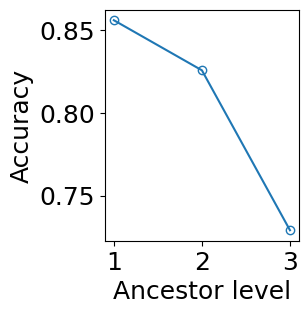

In [9]:
fig,ax = plt.subplots(1,1,figsize=(2.5,3))

for i in range(len(ks)):
    ax.plot(levels,np.max(val_accuracies[:,i,:,-1],axis=0),label=r'$k = {}$'.format(ks[i]),marker='o',ls='-',markerfacecolor='None')
ax.set_xlabel('Ancestor level')
ax.set_ylabel('Accuracy')
#plt.legend()

#plt.savefig('probe_accuracies_0HL.pdf',bbox_inches='tight')

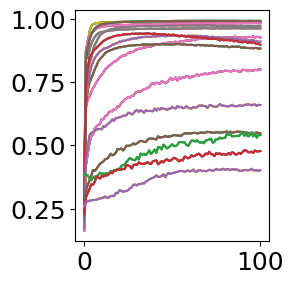

In [26]:
fig,ax = plt.subplots(1,1,figsize=(2.5,3))

for i in range(len(ks)):
    for j in range(len(levels)):
        ax.plot(np.arange(n_epochs+1),val_accuracies[:,i,:,-1],label=r'$k = {}$'.format(ks[i]),marker='',ls='-',markerfacecolor='None')

### Now with truncated fully hierarchical

In [20]:
P = 2**np.arange(9,15)
P = 2**np.arange(14,15)
print(P)

p = 2**18

ks = np.arange(1,l+1)
levels = np.arange(l-1,0,-1)

print(levels)

[16384]
[3 2 1]


In [21]:
loss_fn = torch.nn.CrossEntropyLoss(reduction='none')
optimizer_params = dict(
        lr=1e-4, # correcting for the very small loss due to single token masking
        betas=(0.9, 0.999),
        eps=1e-08,  # 1e-6 for BERT.
        weight_decay=0  # 0.01 for BERT.
    )
decoder_hidden_dim = [64]
n_classes = q
decoder_activation = 'relu'
decoder_batch_normalization = False
decoder_dropout_p = None
n_epochs = 100
batch_size = 32

N_val = int(1e4)
val_accuracies_truncated = np.empty((n_epochs+1,len(ks),len(levels),len(P)))

In [23]:
for i in range(len(ks)):
    MODEL_DIR = './models/model_MLM_1mask_wfactorizedvalNew_{}_{}_{:.2f}_{:.5f}_{}_{}_{}'.format(q,l,sigma,epsilon,seed,p,n_layer)
    #MODEL_DIR = './models/model_MLM_1mask_wfactorizedvalNew_LinearReadout_{}_{}_{:.2f}_{:.5f}_{}_{}_{}'.format(q,l,sigma,epsilon,seed,p,n_layer)
    if ks[i] == 0:
        pretrained_MLM = get_model(MODEL_DIR,device)
    else: 
        pretrained_MLM = get_model_truncated(MODEL_DIR,device,ks[i])
    for j in range(len(levels)):
        [_,_,_,_,xs_ancestor,xis,_,_] = np.load('./sim_data/ancestor_data_fixed_{}_{}_{}_{:.5f}_{}.npy'.format(q,l,sigma,epsilon,levels[j]),allow_pickle=True)
        x_ancestor = xs_ancestor[:,:,seed]
        xi = xis[:,:,seed]
        leaves = torch.from_numpy(xi.T).to(device=device).to(dtype=torch.int64)
        ancestors = torch.nn.functional.one_hot(torch.from_numpy(x_ancestor.T).to(dtype=torch.int64), num_classes=q).to(dtype=torch.float32).to(device=device)
        upsample_factor = 2**l//2**levels[j]
        upsampled_ancestors = ancestors.repeat_interleave(upsample_factor, dim=1)
        x_test = leaves[-N_val:,:]
        y_test = upsampled_ancestors[-N_val:,:,:]
        for k in range(len(P)):
            x_train = leaves[:P[k],:]
            y_train = upsampled_ancestors[:P[k],:,:]
            model = deepcopy(pretrained_MLM)
            model.decoder = FFNN(
                dims=(
                    [model.embedding_size]
                    + decoder_hidden_dim
                    + [n_classes]
                ),
                activation=decoder_activation,
                output_activation='identity',
                batch_normalization=decoder_batch_normalization,
                dropout_p=decoder_dropout_p,
                concatenate_last_dim=False
            )
            model = model.to(device=device)
            freeze_encoder_weights(model,trainable_modules=['decoder'])
            optimizer = torch.optim.Adam(
                params=model.parameters(),
                **optimizer_params
            )
            model,optimizer,training_history = train_model_ancestor_probe((x_train,y_train),model,n_epochs,batch_size,optimizer,val_sequences = (x_test,y_test))
            val_accuracies_truncated[:,i,j,k] = training_history['val_accuracy']

/home/Garnier/miniconda3/envs/default/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
2024-08-02 16:41:03,254 - transformer_encoder_pretraining - INFO - Module: input_embedding| N parameters: 640 | Parameters trainable: False | Training mode: False
2024-08-02 16:41:03,255 - transformer_encoder_pretraining - INFO - Module: positional_embedding| N parameters: 0 | Parameters trainable: True | Training mode: False
2024-08-02 16:41:03,255 - transformer_encoder_pretraining - INFO - Module: encoder_layer| N parameters: 593024 | Parameters trainable: False | Training mode: False
2024-08-02 16:41:03,256 - transformer_encoder_pretraining - INFO - Module: transformer_encoder| N parameters: 1779072 | Parameters trainable: False | Tra

IndexError: index 0 is out of range

Text(0, 0.5, 'Accuracy')

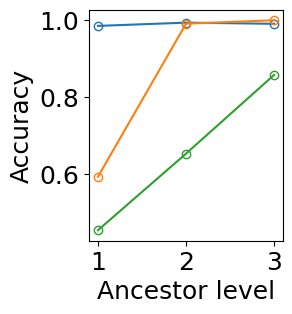

In [26]:
fig,ax = plt.subplots(1,1,figsize=(2.5,3))

for i in range(len(ks)-1):
    ax.plot(levels,np.max(val_accuracies_truncated[:,i,:,-1],axis=0),label=r'$k = {}$'.format(ks[i]),marker='o',ls='-',markerfacecolor='None')
ax.set_xlabel('Ancestor level')
ax.set_ylabel('Accuracy')
#plt.legend()